# Advanced Lane Finding

In this notebook the code and results of the second project "Advanced Lane Finding" is documented.

## Goal
The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicleposition

## Content
1. [Camera Calibration](#1.-Camera-Calibration)
  1.1. [Helper Functions](#1.1.-Helper-Functions)
  1.2. [Calibration Execution](#1.2.-Calibration-Execution)
2. [Pipeline](#2.-Pipeline)
  2.1. [Helper Types](#2.1.-Helper-Types)
  2.2. [Helper Functions](#2.2.-Helper-Functions)
  2.3. [Drawer](#2.3.-Drawer)
  2.4. [Pipeline Implementation](#2.4.-Pipeline-Implementation)
3. [Application to Images](#3.-Application-to-Images)
4. [Application to Videos](#4.-Application-to-Videos)
5. [Writeup](#5.-Writeup)

-------------------------------------
## Load Libs
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>

This section just initializes relevant libraries:

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

-------------------------------------
## 1. Camera Calibration
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


In order to retrieve viable information out of camera data it is neccessary to compensate for the camera distortion. This section includes the neccessary content and scripts to calculate the distortion matrix out of various measurements.



### 1.1. Helper Functions
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


In [2]:
### Method to return calibration for a batch of images
def cal_cam(cal_files, nx, ny,debug=0,debug_folder="cal_camera_out"):
    """
    Desc.: Procedure for to return camera calibration data
    
    Input:
    cal_files    : is a list of files containing calibration images
    nx           : number of internal corners per row on a chessboard
    ny           : number of internal corners per column on a chessboard
    debug        : debug level (0: no display or texts (default); 1: text only; 2: figures and text)
                   3: save test images )
    debug_folder: in case debug==3, where should the images saved to

    Output:
    ret          : return value that gives the status of the calibration;
                   0 = unsuccessful; 1 = images_found; 2 = valid calibration matrices;
    
    Implementation based on and reuses parts of a open-cv tutorial:
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
    Actually this tutorial was a bit more suitable for my style of learning.
    """
    
    # prepare output flag
    ret_val = 0 # return value 

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    filenames = [] # list with successful converted files
    
    # Remember sizes to skip files which do not have the same resolution as the previous ones
    size =[None,None]
        
    # check if target directory exists; if not create it
    if (not os.path.exists(debug_folder)) & (debug > 2):
        os.mkdir(debug_folder)
    
    # iterate through batch
    for file in cal_files:
        img = mpimg.imread(file)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        if size[0] is None:
            size[0] = img.shape[0]
            size[1] = img.shape[1]
        else:
            if (size[0] != img.shape[0]) & (size[1] != img.shape[1]):
                if debug > 0:
                    print(\
                    "Skipping file '{}' as it has not the same format as previous images:\n".format(file) + \
                    " {}x{}(prev. images) vs. {}x{}(this image)".format(img.shape[1],img.shape[0],size[1],size[0]))
                continue                

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            if debug > 0:
                print("Chessboards successfully identified for file '{}'.".format(file))
                        
            filenames.append(file)
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
            
        else: # Nothing found, then tell us?
            if debug > 0:
                print("No chessboards found for file '{}'.".format(file))
            if debug > 1:
                plt.imshow(img)
                plt.show()
    
    # init output in the case of failures
    ret   = 99999; 
    mtx   = None
    dist  = None 
    rvecs = None
    
    # do we have enough data for the calibration
    if len(objpoints) > 0:
        if debug > 0:
            print("Useful Data found ({} Files) -> Proceeding to calibration".format(len(objpoints)))
        ret_val = 1 # set ret val to one as we found some images
        
        # Run Calibration
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    # was the calibration successful
    if (np.absolute(ret)/len(objpoints)) < 0.1: # some random sanity check for enough calibration quality
        if debug > 0:
            print("Creating Calibration matrices was successful".format(len(objpoints)))
        ret_val = 2 # set ret val to one as we found some images
        

        # Draw and display the resulting images
        if debug > 1:
            for (corners,points,file) in zip(imgpoints,objpoints,filenames):
                #read image
                img = mpimg.imread(file)
                img_corner = np.copy(img)
                img_undst = np.copy(img)
                
                fig,a = plt.subplots(1,3) ## initialize subplots for comparison init to end
                
                # show original image
                a[0].imshow(img)
                a[0].set_title("Original Image")
                
                # draw chessboard corners
                img_corner = cv2.drawChessboardCorners(img_corner, (nx,ny), corners,True)
                a[1].imshow(img_corner)
                a[1].set_title("Corners")
                
                # undistort
                img_undst = cv2.undistort(img_undst, mtx, dist, None, mtx)
                a[2].imshow(img_undst)
                a[2].set_title("Undistorted")
                plt.show()
                
                if debug > 2: # ok, you want to save the whole stuff
                    fname = os.path.basename(file)  
                    (file_, ext) = os.path.splitext(fname)
                    mpimg.imsave(debug_folder + "/" + file_ + "_orig"   + ext,img)
                    mpimg.imsave(debug_folder + "/" + file_ + "_corner" + ext,img_corner)
                    mpimg.imsave(debug_folder + "/" + file_ + "_undist" + ext,img_undst)
    else:
        if debug > 0:
            print("Calibration procedure failed")
                    
    return ret_val, mtx, dist, rvecs, tvecs

### 1.2. Calibration Execution
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>

Run the Calibration procedure with a specific set of images

In [3]:
### Run Calibration

# set Properties
nx_cb = 9 # number corners per row
ny_cb = 6 # number corners per column
images = glob.glob('camera_cal/calibration*.jpg')

# cal calibration method
ret_val, mtx, dist, rvecs, tvecs = cal_cam(images, nx_cb, ny_cb,0) # set last input to 3 to print debug msgs.

# set camera_vals
cam_calib_data = [mtx,dist]

if ret_val == 2:
    print("Camera Calibration successful!")


Camera Calibration successful!


## 2. Pipeline
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


### 2.1. Helper Types
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


In [4]:
### Line Class
class Line():
    def __init__(self):
        # steps, the current lane is old
        self.age = -1
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit_coefs = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_x = None 
        #curvature of the line in some 1/m
        self.curvature = None 
        #distance in meters of vehicle center from the line
        self.orientation = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        #weight for detected line pixels
        self.allw = None
        # name
        self.name = None
        # confidence of current measurement
        self.confidence = 0
        
### Lane Class
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # steps, the current lane is old
        self.age = -1
        # width of the detected lane
        self.width = None
        # curvature of the lane
        self.curvature = None
        
### Properties for detection algo
class LaneDetectionProps():
    def __init__(self):
        self.threshold_curvature = 0.05  
        self.max_age = 10
        self.min_lane_width = 2
        self.max_lane_width = 4.5
        self.min_line_orientation = -np.pi/4 # in rad
        self.max_line_orientation = np.pi/4  # in rad
        self.min_line_curvature = -0.05       # in 1/m
        self.max_line_curvature = 0.05       # in 1/m
        self.cam_mtx = None
        self.cam_dist = None
        self.persp_src = None
        self.persp_dst = None
        self.persp_px2m = 1
        self.persp_py2m = 1
        self.bs_nWindows = 9
        self.bs_margin = 0.4 # in m
        self.bs_backtracking = 1.3
        self.bs_minpx_dens = 0.05 # pixeldensity defined for smallest window -> 0.05 means 20% of a 10cm line
        self.bs_max_margin = 1 # in m
        self.hist_filtlength = 0.05 # in m
        self.debug = 0
        self.debug_folder = "output"
        self.debug_name   = "dummy"
        self.debug_hist   = 0
        self.warp_mat  = None
        self.warp_mat_inv = None
        self.plot_y = None
        self.lf_min_pts_ = 20
        self.min_conf = 0.1
        self.img_size = None

### 2.2. Helper Functions
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


In [5]:
# initialization function e.g. to determine constant parameters
def initialize_pipeline(img,line_left,line_right,lane,props):
    #calculate the warp matrices just once
    if props.warp_mat is None:
        props.warp_mat = cv2.getPerspectiveTransform(props.persp_src, props.persp_dst)
    if props.warp_mat_inv is None:
        props.warp_mat_inv = cv2.getPerspectiveTransform(props.persp_dst, props.persp_src)
    if props.plot_y is None:
        props.plot_y = np.linspace(0, np.max(props.persp_dst[:,1]), np.int_(np.max(props.persp_dst[:,1])+1) )
    if props.img_size is None:
        props.img_size = img.shape;
    
    # add one step to age if lane or line was valid before
    if line_left.age >= 0:
        line_left.age = np.maximum(0,line_left.age + 1)
    if line_right.age >= 0:
        line_right.age = np.maximum(0,line_right.age + 1)
    if lane.age >= 0:
        lane.age = np.max(0,lane.age + 1)
        
        
    if line_left.name is None:
        line_left.name = "left_line"
    if line_right.name is None:
        line_right.name = "right_line"

# fit polynom for a given line with detected points
def fit_polynomial_line(line,props):
    
    # Reset fitted values to Error value
    line.current_fit_x = None
    
    if len(line.ally) >= props.lf_min_pts_:
        # Fit a second order polynomial to each using `np.polyfit`
        current_fit_coefs = np.polyfit(line.ally, line.allx, 2, w=line.allw)

        # Generate x for plotting
        try:
            current_fit_x = current_fit_coefs[0]*props.plot_y**2 + \
                            current_fit_coefs[1]*props.plot_y    + \
                            current_fit_coefs[2]
        except TypeError:
             # Avoids an error if `left` and `right_fit` are still none or incorrect
             print('The function failed to fit a line!')
        
        ## everything alright then save stuff
        if (1):
            line.current_fit_x = current_fit_x
            line.current_fit_coefs = current_fit_coefs
    
    return line

# perform a blockwise search to find a new line
def find_line_pixels_blocksearch(img_warped_feature, line_x_base,line, props):        
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img_warped_feature.shape[0]//props.bs_nWindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero  = img_warped_feature.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    nonzerow = np.array(nonzero[2])
    
    # Current positions to be updated later for each window in nwindows
    line_x_current = line_x_base
    line_ws_current = int(props.bs_margin/props.persp_px2m)

    # Create empty lists to receive left and right lane pixel indices
    line_inds = []
    
    # create dummy output and fill it in case debug is requested
    out_img = []
    if props.debug > 1:
        out_img = np.copy(np.uint8(img_warped_feature))

    # Step through the windows one by one
    for window in range(props.bs_nWindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_warped_feature.shape[0] - (window+1)*window_height
        win_y_high = img_warped_feature.shape[0] - window*window_height
        win_x_line_low = line_x_current - line_ws_current//2
        win_x_line_high = line_x_current + line_ws_current//2
        
        # Draw the windows on the visualization image
        if props.debug > 1:
            cv2.rectangle(out_img,(win_x_line_low,win_y_low),
            (win_x_line_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_x_line_low) &  (nonzerox < win_x_line_high)).nonzero()[0]
                     
        # Append these indices to the lists
        line_inds.append(good_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > props.bs_minpx_dens*window_height*line_ws_current:
            line_x_current = np.int(np.mean(nonzerox[good_inds]))
            line_ws_current = int(props.bs_margin/props.persp_px2m)
        else:
            line_ws_current = np.min([int(props.bs_max_margin/props.persp_px2m), \
                int(line_ws_current*props.bs_backtracking)])
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        line_inds = np.concatenate(line_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    line.allx = nonzerox[line_inds]
    line.ally = nonzeroy[line_inds] 
    line.allw = nonzerow[line_inds] 
    
    # generate a line confidence
    # sumarize the average weight of every found indizes
    # add  the density of the found pixels
    # substract the density of relevant pixels in the whole image
    line.confidence = float(np.sum(line.allw)/120.0)/float(len(line_inds)) + \
    float(len(line_inds))/float(props.bs_nWindows*window_height*props.bs_margin/props.persp_px2m) - \
    float(len(nonzerow))/float(img_warped_feature.shape[1]*img_warped_feature.shape[0])
    
    if props.debug > 2:
        out_img[out_img[:,:,:] > 0] = 255
        out_img[line.ally,line.allx,:] = (255,0,0)
        mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_bs_" + line.name +'.jpg',out_img)

    return line

def search_around_poly(img_warped_feature,line,props):
    # range to search
    margin = int(props.bs_margin/props.persp_px2m)

    # Grab activated pixels
    nonzero = img_warped_feature.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    nonzerow = np.array(nonzero[2])
    
    line_inds = ((nonzerox > (line.best_fit[0]*(nonzeroy**2) + line.best_fit[1]*nonzeroy + 
                    line.best_fit[2] - margin)) & (nonzerox < (line.best_fit[0]*(nonzeroy**2) + 
                    line.best_fit[1]*nonzeroy + line.best_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    line.allx = nonzerox[line_inds]
    line.ally = nonzeroy[line_inds]
    line.allw = nonzerow[line_inds]
    
    # generate a line confidence
    # sumarize the average weight of every found indizes
    # add  the density of the found pixels
    # substract the density of relevant pixels in the whole image
    line.confidence = float(np.sum(line.allw)/120.0)/float(len(line_inds)) + \
    float(len(line_inds))/float((img_warped_feature.shape[0]*margin)) - \
    float(len(nonzerow))/float(img_warped_feature.shape[1]*img_warped_feature.shape[0])
    
    # create dummy output and fill it in case debug is requested
    if props.debug > 1:
        out_img = np.copy(np.uint8(img_warped_feature))
        
        if props.debug > 2:
            out_img[out_img[:,:,:] > 0] = 255
            out_img[line.ally,line.allx,:] = (255,0,0)
            window_img = np.zeros_like(out_img)

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            line_window1 = np.array([np.transpose(np.vstack([line.bestx-margin, props.plot_y]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([line.bestx+margin,props.plot_y])))])
            line_pts = np.hstack((line_window1, line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_sp_" + line.name +'.jpg',result)
    
    return line

# find a new starting point for lines
def find_line_pixels_startpoint(img_warped_feature, props):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = (np.sum(img_warped_feature[img_warped_feature.shape[0]//2:,:], axis=0).
                 astype(np.float))/float((img_warped_feature.shape[0]//2)*255)
   
    # histogram smoothing to avoid single unintended peaks .. the peak should be significant
    filter_length = 5
    for i in range(3):
        #histogram[histogram[:,i] < np.mean(histogram[:,i]),i] = 0
        for k in range(img_warped_feature.shape[1] - filter_length):
             histogram[k,i] = np.sum(histogram[k:k + filter_length,i])/filter_length
        for k in range(img_warped_feature.shape[1] - 1,-1+filter_length,-1):
             histogram[k,i] = np.sum(histogram[k-filter_length+1:k+1,i])/filter_length
                    
    histogram_eff = histogram[:,0]*0.2 + histogram[:,1]*0.3 + histogram[:,2]*0.5
    
    histogram = np.transpose(np.vstack((histogram[:,0],histogram[:,1],histogram[:,2],histogram_eff)))
    
    img_warped_weighted = np.zeros_like(img_warped_feature)
    img_warped_weighted[:,:,0] = img_warped_feature[:,:,0]*0.2 + img_warped_feature[:,:,1]*0.3 + img_warped_feature[:,:,2]*0.5

    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram_eff.shape[0]//2)
    left_x_base = np.argmax(histogram_eff[:midpoint])
    right_x_base = np.argmax(histogram_eff[midpoint:]) + midpoint  
    
    search_max = 5
    range_s = range(int(np.maximum(0,left_x_base-search_max)),int(np.minimum(len(histogram_eff),left_x_base+search_max+1)))
    sum_ = ((np.max(histogram[range_s,0]) < 0.15) + (np.max(histogram[range_s,1]) < 0.15) + (np.max(histogram[range_s,2]) < 0.2))
    if sum_ > 1:
        left_x_base = -1
        
    range_s = range(int(np.maximum(0,right_x_base-search_max)),int(np.minimum(len(histogram_eff),right_x_base+search_max+1)))
    sum_ = ((np.max(histogram[range_s,0]) < 0.15) + (np.max(histogram[range_s,1]) < 0.15) + (np.max(histogram[range_s,2]) < 0.2))
    if sum_ > 1:
        right_x_base = -1
            
    return left_x_base, right_x_base, histogram, img_warped_weighted

def calculate_line_feature_image(img_undst,props):
    
    s_thresh=(120, 255)
    sx_thresh=(10, 100)
    l_tresh = (220,255) # high light intensity -> white
    h_tresh = (30//2, 70//2) # -> hue test if hue indicates for a yellow line (hue is mapped from 0-180)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img_undst, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    
    # Sobel x
    sobelx_l = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx_l = np.absolute(sobelx_l) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx_l = np.uint8(255*abs_sobelx_l/np.max(abs_sobelx_l))
    
    # Threshold x gradient
    scaled_sobelx_l[(scaled_sobelx_l < sx_thresh[0]) | (scaled_sobelx_l > sx_thresh[1]) ] = 0
    scaled_sobelx_l[scaled_sobelx_l > 0] = np.maximum(100,scaled_sobelx_l[scaled_sobelx_l > 0])
    
    # Threshold color channel
    s_channel[(s_channel < s_thresh[0]) | (s_channel > s_thresh[1])] = 0
    
    hl_channel = np.uint8(np.maximum(np.uint8(np.absolute(h_channel-25)*255/20), l_channel))
    hl_channel[((h_channel < h_tresh[0]) | (h_channel > h_tresh[1]) | (s_channel < 150) | (l_channel < 100)) & 
               ((l_channel < l_tresh[0]) | (l_channel > l_tresh[1]))] = 0
    
    # Stack each channel
    # no binary conversion is performed to use each value for weighting the polynom fitting later steps
    img_undst_feature = np.dstack(( hl_channel, scaled_sobelx_l, s_channel))
    
    # debug out
    if props.debug > 1:
        plt.figure() ## initialize subplots for comparison init to end
        plt.imshow(img_undst_feature) ## write original image
        plt.show() ## present results
    
    return img_undst_feature

def transfrom_cam2birdseye(img_undst,img_undst_feature,img,props):    
    # transform to birdseye view
    img_warped = cv2.warpPerspective(img_undst, props.warp_mat, (img_undst.shape[1], len(props.plot_y)))
    img_warped_feature = cv2.warpPerspective(img_undst_feature, props.warp_mat, (img_undst.shape[1], len(props.plot_y)))
    
    if props.debug > 1:
        img_undst_per = np.copy(img_undst)
        cv2.line(img_undst_per,(props.persp_src[0][0], props.persp_src[0][1]),
             (props.persp_src[1][0], props.persp_src[1][1]),[255, 0, 0],2) 
        cv2.line(img_undst_per,(props.persp_src[1][0], props.persp_src[1][1]),
             (props.persp_src[2][0], props.persp_src[2][1]),[255, 0, 0],2)
        cv2.line(img_undst_per,(props.persp_src[2][0], props.persp_src[2][1]),
             (props.persp_src[3][0], props.persp_src[3][1]),[255, 0, 0],2)
        cv2.line(img_undst_per,(props.persp_src[3][0], props.persp_src[3][1]),
             (props.persp_src[0][0], props.persp_src[0][1]),[255, 0, 0],2) 
    
        img_warped_per = np.copy(img_warped)
        cv2.line(img_warped_per,(props.persp_dst[0][0], props.persp_dst[0][1]),
             (props.persp_dst[1][0], props.persp_dst[1][1]),[255, 0, 0],2) 
        cv2.line(img_warped_per,(props.persp_dst[1][0], props.persp_dst[1][1]),
             (props.persp_dst[2][0], props.persp_dst[2][1]),[255, 0, 0],2)
        cv2.line(img_warped_per,(props.persp_dst[2][0], props.persp_dst[2][1]),
             (props.persp_dst[3][0], props.persp_dst[3][1]),[255, 0, 0],2)
        cv2.line(img_warped_per,(props.persp_dst[3][0], props.persp_dst[3][1]),
             (props.persp_dst[0][0], props.persp_dst[0][1]),[255, 0, 0],2) 
        
        # draw output
        print("Result of undistortion and warping for image '{}'".format(props.debug_name))
        fig,a = plt.subplots(1,3) ## initialize subplots for comparison init to end
        a[0].imshow(img) ## write original image
        a[0].set_title("Original Image")
        a[1].imshow(img_undst_per) # set undistorted image
        a[1].set_title("Undistorted Image")
        a[2].imshow(img_warped_per) # set warped image
        a[2].set_title("Warped Image")
        plt.show() ## present results
        
        img_undst_feature_bin = np.copy(img_undst_feature)
        for i in range(img_undst_feature_bin.shape[0]):
            for j in range(img_undst_feature_bin.shape[1]):
                if (np.sum(img_undst_feature_bin[i,j,:]) > 0):
                    img_undst_feature_bin[i,j,:] = (255,255,255)
        
        if props.debug > 2:
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_raw"            +'.jpg',img)
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_undst"          +'.jpg',img_undst)
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_undst_feat"     +'.jpg',img_undst_feature)
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_undst_feat_bin" +'.jpg',img_undst_feature_bin)
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_undst_per"      +'.jpg',img_undst_per)
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_warped"         +'.jpg',img_warped)
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_warped_per"     +'.jpg',img_warped_per)
            mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_warped_feat"    +'.jpg',img_warped_feature)
        
    
    return img_warped, img_warped_feature

#undo warping for projection of annotations in camera image
def transfrom_birdseye2cam_undst(img_warped,img_undst,props):
        
    # transform to birdseye view
    img_undst = cv2.warpPerspective(img_warped, props.warp_mat_inv, (img_undst.shape[1], img_undst.shape[0]))
    
    return img_undst 


#test if line is valid
def test_line(line_to_check, valid_line,valid_lane,props):
    # get properties at vehicle basepoint
    #evaluate line and its derivative
    x = line_to_check.current_fit_coefs[0]*(props.plot_y[-1]**2) + line_to_check.current_fit_coefs[1]*props.plot_y[-1] + line_to_check.current_fit_coefs[2]
    dx = 2*line_to_check.current_fit_coefs[0]*(props.plot_y[-1]) + line_to_check.current_fit_coefs[1]
    ddx = 2*line_to_check.current_fit_coefs[0]
    
    # convert to world coordinates
    x *= props.persp_px2m
    dx *= props.persp_px2m/props.persp_py2m
    ddx *= props.persp_px2m/props.persp_py2m/props.persp_py2m
    
    # get deviation from center
    line_base_pos = -(x-props.img_size[1]//2*props.persp_px2m)
    
    # get line orientation
    orientation = np.arctan(-dx)
    
    # get line curvature
    curvature = -ddx / (1 + (dx)**2)**(3/2)
    
    if ((curvature > props.max_line_curvature) | (curvature < props.min_line_curvature) |  \
       (orientation > props.max_line_orientation) | (orientation < props.min_line_orientation)):
        line_to_check.current_fit_x = None      
    
    return line_to_check

# integrate new line in fitting result
def finalize_results(line,props):
    if line.confidence >= props.min_conf:
        # is this the first line or did we found one before
        if ((line.detected is True) & (line.age <= props.max_age)  & (line.age >= 0)):
            weight_new = np.maximum(0.1,np.minimum(0.4,line.confidence/3)) # set weight depending on confidence
            line.allx = np.hstack((line.current_fit_x,line.bestx))
            line.ally = np.hstack((props.plot_y,props.plot_y))
            line.allw = np.hstack((np.ones_like(line.current_fit_x)*weight_new*255,np.ones_like(line.bestx)*255)).astype(np.uint8)
            line  = fit_polynomial_line(line,  props)
            line.detected = True
            line.bestx = line.current_fit_x
            line.best_fit = line.current_fit_coefs
            line.age = 0
        else: # ok first line so just set the line
            line.detected = True
            line.bestx = line.current_fit_x
            line.best_fit = line.current_fit_coefs
            line.age = 0
        
        # as we now got a new line .. we can set its properties
        #evaluate line and its derivative
        x = line.best_fit[0]*(props.plot_y[-1]**2) + line.best_fit[1]*props.plot_y[-1] + line.best_fit[2]
        dx = 2*line.best_fit[0]*(props.plot_y[-1]) + line.best_fit[1]
        ddx = 2*line.best_fit[0]
        
        # convert to world coordinates
        x *= props.persp_px2m
        dx *= props.persp_px2m/props.persp_py2m
        ddx *= props.persp_px2m/props.persp_py2m/props.persp_py2m
    
        # get deviation from center
        line.line_base_pos = -(x-props.img_size[1]//2*props.persp_px2m)
    
        # get line orientation
        line.orientation = np.arctan(-dx)
    
        # get line curvature
        line.curvature = -ddx * (1 + dx**2)**(-1.5)
    
    return line

### 2.3. Drawer
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


In [6]:
def draw_and_annotate(img_undst,img_warped,line_left,line_right,lane,histogram,props):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    if line_left.detected:
        pts_left = np.array([np.transpose(np.vstack([line_left.bestx, props.plot_y]))])
        cv2.polylines(warp_zero, np.int_([pts_left]),0, (210,0,0),4)
    if line_right.detected:
        pts_right = np.array([np.flipud(np.transpose(np.vstack([line_right.bestx, props.plot_y])))])
        cv2.polylines(warp_zero, np.int_([pts_right]),0, (210,0,0),4)
    
    if line_left.detected & line_right.detected:
        pts = np.hstack((pts_left, pts_right))
    
        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255,0))
        
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = transfrom_birdseye2cam_undst(warp_zero,img_undst,props)
        
    #Combine the result with the original image
    img_undst_annotated = cv2.addWeighted(img_undst, 1, newwarp, 0.3, 0)
    
    if props.debug_hist > 0:
        warp_zero = np.zeros_like(img_undst).astype(np.uint8)
        for ii in range(warp_zero.shape[1]):
            for jj in range(warp_zero.shape[0]-90,warp_zero.shape[0]):
                warp_zero[jj,ii,:] = (255,255,255)
    
        histogram_y = np.int_(np.ones_like(histogram)*(warp_zero.shape[0] - 1) - histogram*70 -10)
        
        for ii in range(warp_zero.shape[1]):
            cv2.circle(warp_zero, (ii,histogram_y[ii,0]), 2, (255, 0,   255), 2)
            cv2.circle(warp_zero, (ii,histogram_y[ii,1]), 2, (255, 0,     0), 2)
            cv2.circle(warp_zero, (ii,histogram_y[ii,2]), 2, (0,   255,   0), 2)
            cv2.circle(warp_zero, (ii,histogram_y[ii,3]), 2, (0,   0,   255), 2)
    
        img_undst_annotated_temp = np.copy(img_undst_annotated)
        cv2.addWeighted(warp_zero, 0.7, img_undst_annotated_temp, 0.3,0, img_undst_annotated_temp)
    
        for jj in range(0,warp_zero.shape[0]-90):
            img_undst_annotated_temp[jj,:,:] = img_undst_annotated[jj,:,:]
            
        img_undst_annotated = img_undst_annotated_temp
        
    
    if line_left.detected & line_right.detected:
        warp_zero = np.zeros_like(img_undst).astype(np.uint8)
        curvature = (line_right.curvature + line_left.curvature)*0.5
        curvature = np.sign(curvature)*np.maximum(0.000001,np.absolute(curvature))
        radius = 1/curvature
        warp_zero = cv2.putText(warp_zero, "Lane Radius is {:=+5d} m".format(int(radius)), (50, 50) , cv2.FONT_HERSHEY_SIMPLEX ,  
                   1.5, (255,255,255), 3, cv2.LINE_AA)
                                    
        dist = -0.5*(line_right.line_base_pos + line_left.line_base_pos)               
        warp_zero = cv2.putText(warp_zero, "Distance from lane center is {:.2f} m".format(dist), (50, 100) , cv2.FONT_HERSHEY_SIMPLEX ,  
                   1.5, (255,255,255), 3, cv2.LINE_AA)
        cv2.addWeighted(warp_zero, 1, img_undst_annotated, 1,0, img_undst_annotated)
    
    return img_undst_annotated

### 2.4. Pipeline Implementation
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


In [7]:
def pipeline_lanefinding(img,props,line_left=Line(),line_right=Line(),lane=Lane()):
    """
    
    Input:
    img: Image data in BRG
    properties: calibration data as list mtx = el[0], dist = el[1];
    line_left: Data of last estimated left line, if nothing is provided, no history is assumed
    line_right: Data of last estimated right line, if nothing is provided, no history is assumed
    lane: Data of last estimated lane, if nothing is provided, no history is assumed
    
    Output:
    img_out: The modified image containign the visualized lane and the approximated lane curvature/radius
    line_left: Contains data about the currently estimated line on the left side
    line_right: Contains data about the currently estimated line on the right side
    lane: Contains data about the whole lane e.g. lane_width
    
    """
    ##init stuff  
    initialize_pipeline(img,line_left,line_right,lane,props)
    
    # check if target directory exists; if not create it
    if (not os.path.exists(props.debug_folder)) & (props.debug > 2):
        os.mkdir(props.debug_folder)
        
    ##### Start Pipeline #####    
    # first remove distortion from image
    img_undst = cv2.undistort(img, props.cam_mtx, props.cam_dist, None, props.cam_mtx)
    
    img_undst_feature = calculate_line_feature_image(img_undst,props)
    
    img_warped, img_warped_feature = transfrom_cam2birdseye(img_undst,img_undst_feature,img,props)
    
    # get us
    left_x_base, right_x_base, histogram, img_warped_weighted = find_line_pixels_startpoint(img_warped_feature, props)
    
    ## check if the have detected a line then reuse it to aquire a new solution
    if ((line_left.detected is True) & (line_left.age <= props.max_age)  & (line_left.age >= 0)):
        line_left  = search_around_poly(img_warped_feature,line_left,props)
        line_left  = fit_polynomial_line(line_left,  props)
        if (line_left.current_fit_coefs is not None):
            if ((lane.detected is True) & (lane.age <= props.max_age)  & (lane.age >= 0)):
                line_left = test_line(line_left, None,lane,props)                
            elif ((line_right.detected is True) & (line_right.age <= props.max_age)  & (line_right.age >= 0)):
                line_left = test_line(line_left, line_right,None,props)
            else:
                line_left = test_line(line_left, None,None,props)
    # same for the right line
    if ((line_right.detected is True) & (line_right.age <= props.max_age)  & (line_right.age >= 0)):
        line_right  = search_around_poly(img_warped_feature,line_right,props)
        line_right  = fit_polynomial_line(line_right,  props)
        if (line_right.current_fit_coefs is not None):
            if ((lane.detected is True) & (lane.age <= props.max_age)  & (lane.age >= 0)):
                line_right = test_line(line_left, None,lane,props)                
            elif ((line_left.detected is True) & (line_left.age <= props.max_age)  & (line_left.age >= 0)):
                line_right = test_line(line_right, line_left,None,props)
            else:
                line_right = test_line(line_right, None,None,props)
                
    ## if we dont have a detected line yet or the line data is outdated restart search
    if ((line_left.detected is False)  | (line_left.age >= props.max_age)  | (line_left.age < 0)):
        line_left  = find_line_pixels_blocksearch(img_warped_feature,  left_x_base, line_left,  props)  
        if (line_left.allx is not None):    
            line_left  = fit_polynomial_line(line_left,  props)
            if (line_left.current_fit_x is not None):
                line_left = test_line(line_left, None,None,props)
                
                    
    # same for the right line
    if ((line_right.detected is False) | (line_right.age >= props.max_age) | (line_right.age < 0)):    
        line_right = find_line_pixels_blocksearch(img_warped_feature, right_x_base, line_right, props) 
        if (line_right.allx is not None):    
            line_right  = fit_polynomial_line(line_right,  props)
            if (line_right.current_fit_x is not None):
                line_right = test_line(line_right, None,None,props)
    
    # finalize the results (smoothing)
    if (line_left.current_fit_x is not None):
        finalize_results(line_left,props)
    if (line_right.current_fit_x is not None):
        finalize_results(line_right,props)
        
    
    img_undst_annotated = draw_and_annotate(img_undst, img_warped, line_left,line_right, lane, histogram, props)
    
    # output final image
    if props.debug > 2:
        mpimg.imsave(props.debug_folder +"/"+ props.debug_name +"_final" +'.jpg',img_undst_annotated)
    
    return img_undst_annotated, line_left, line_right, lane

## 3. Application to Images
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


In [8]:
## set options
# set path variables 
output_path = "output_images"
input_path  = "test_images"

# check if target directory exists; if not create it
if not os.path.exists(output_path):
    os.mkdir(output_path)

Props = LaneDetectionProps();
Props.cam_mtx = cam_calib_data[0]
Props.cam_dist = cam_calib_data[1]
offset_x_u = 222
offset_x_o = 612 # 440
offset_x_o = 564 # 470; off~(700-470)*1.487 + 222
Props.persp_src = np.float32([(offset_x_u,700),(offset_x_o,470),(1279-offset_x_o,470),(1279-offset_x_u,700)])
Props.persp_dst = np.float32([(offset_x_u,600),(offset_x_u,0)  ,(1279-offset_x_u,0)  ,(1279-offset_x_u,600)])
Props.persp_px2m = 3.5/(1280-2*offset_x_u)
Props.persp_py2m = 20/600


Results for image straight_lines1:



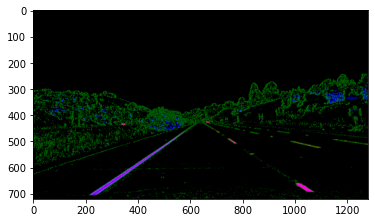

Result of undistortion and warping for image 'straight_lines1'


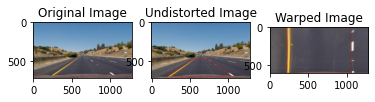

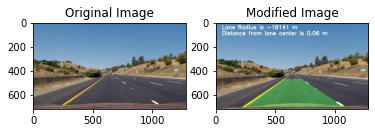

Results for image straight_lines2:



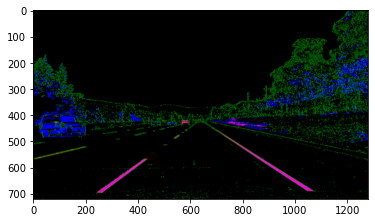

Result of undistortion and warping for image 'straight_lines2'


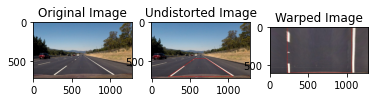

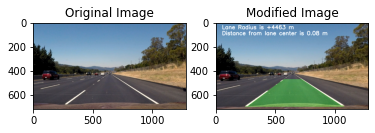

Results for image test1:



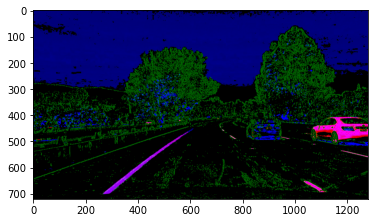

Result of undistortion and warping for image 'test1'


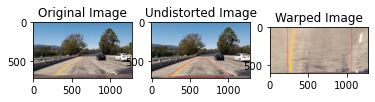

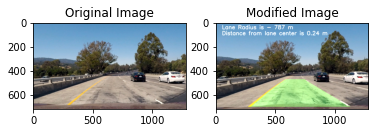

Results for image test2:



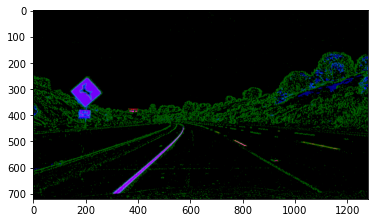

Result of undistortion and warping for image 'test2'


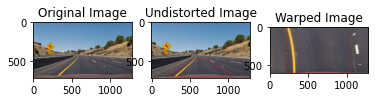

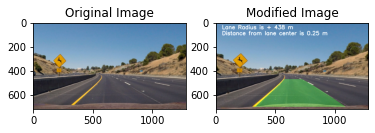

Results for image test3:



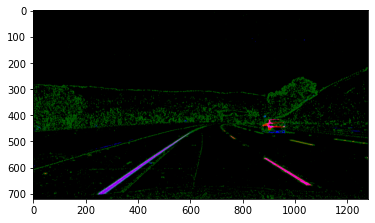

Result of undistortion and warping for image 'test3'


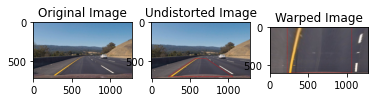

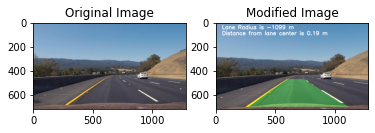

Results for image test4:



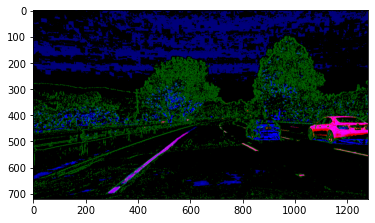

Result of undistortion and warping for image 'test4'


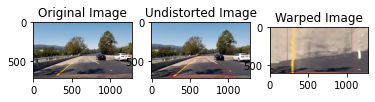

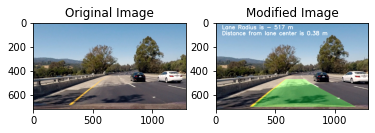

Results for image test5:



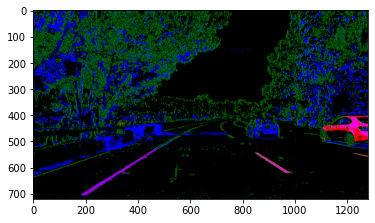

Result of undistortion and warping for image 'test5'


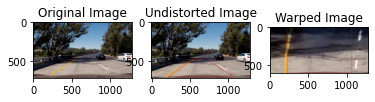

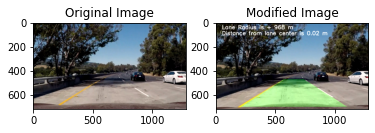

Results for image test6:



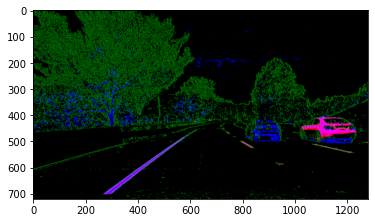

Result of undistortion and warping for image 'test6'


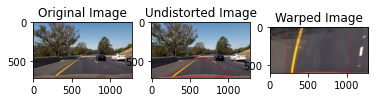

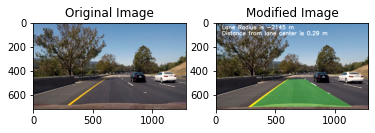

In [9]:
### run on images
    
Props.debug = 3
Props.debug_folder = output_path

# get all files
files = os.listdir(input_path)
#files = ["test2.jpg"]
for file in files:
    if file[-3:] == 'jpg': ## check if its a jpg
        ## Initialization part
        image = mpimg.imread(input_path + "/" + file) ## read image
        print("Results for image {}:\n".format(file[:-4]))
        # init buffers        
        lane_buffer = Lane()
        line_left_buffer = Line()
        line_right_buffer = Line()
        
        # set name for images
        Props.debug_name = file[:-4]
        
        ## get modified image
        img_out, line_left, line_right,lane = pipeline_lanefinding(image,Props,
                                                          line_left = line_left_buffer,
                                                          line_right = line_right_buffer,
                                                          lane = lane_buffer)
        
        ## Postprocess
        fig,a = plt.subplots(1,2) ## initialize subplots for comparison init to end
        a[0].imshow(image) ## write original image
        a[0].set_title("Original Image")
        a[1].set_title("Modified Image")
        a[1].imshow(img_out) # set modified image
        
        ## Output
        plt.show() ## present results
        #break # break after first
        

### 4. Application to Videos
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


In [10]:
# initialize lane data
lane_buffer = Lane()
line_left_buffer = Line()
line_right_buffer = Line()

output_path = "output_videos"
input_path  = "test_videos"

count = 0;

Props.debug=0
Props.debug_folder = "output_video_frames"

# what video should be processed
name = "project_video"
#name = "challenge_video"

# check if target directory exists; if not create it
if not os.path.exists(output_path):
    os.mkdir(output_path)

    
# define method to process an image frame with the lane detection pipeline
def process_frame(img):
    # set the buffer as global variables to make them persistent during batch execution
    global line_left_buffer
    global line_right_buffer
    global lane_buffer
    global Props
    global count
    global name
    count = count + 1
    Props.debug_name = name + str(count)
    
    img_out, line_left_buffer, \
    line_right_buffer, lane_buffer = pipeline_lanefinding(\
                                                          img,Props,
                                                          line_left = line_left_buffer,
                                                          line_right = line_right_buffer,
                                                          lane = lane_buffer)
    return img_out # returns a 8-bit RGB array


clip = VideoFileClip("test_videos/"+ name +".mp4") # or .avi, .webm, .gif ...#
#clip = VideoFileClip(input_path + "/" + name + ".mp4").subclip(0,10)
video_clip = clip.fl_image(process_frame)
%time video_clip.write_videofile(output_path + "/" + name + ".mp4", audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video1.mp4.
Moviepy - Writing video output_videos/project_video1.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video1.mp4
Wall time: 6min 45s


###### Here is the result:

In [14]:
output_path = "output_videos"

HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output_path + "/" + name + ".mp4"))

------------------------------
-----------------------------
## 5. Writeup
<font size="-3">[to the Top](#Advanced-Lane-Finding)</font>


### Camera Calibration
##### Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.
To compensate for the distortion I used the provided chessboard-images. The whole calibration procedure is conduct in the method ```def cal_cam```. First all images are processed. The image shape, which is accepted by the algorithmn is freezed after the first image to avoid wrongly calibrated image due to erronious images. E.g. in this case there were 4 images of size 1280x721 instead of the required resulotion 1280x720. Those are therefore rejected. Then the internal nodes in the chessboards are identified using ```cv2.findChessboardCorners```. Those pictures which don't result in an 9x6 image where also sorted out. Reasons are e.g. non visible corners on the image.
With the accumulated ```objpoints``` and ```imgpoints``` I used the method ```cv2.calibrateCamera``` to obtain the calibration and distortion matrices. With this matrices the subsequent images are corrected:

Original
<img src="cal_camera_out/calibration2_orig.jpg" alt="cal_camera_orig" width="320" height="180"> 
Undistorted
<img src="cal_camera_out/calibration2_undist.jpg" alt="cal_camera_undist" width="320" height="180"> 


### The Pipeline for images
##### Provide an example of a distortion-corrected image.

The effect is best visible if you take a look at the ego-vehicle's bonnet:

Original
<img src="output_images/straight_lines1_raw.jpg" alt="cal_camera_orig" width="320" height="180"> 
Undistorted
<img src="output_images/straight_lines1_undst.jpg" alt="cal_camera_undist" width="320" height="180">

##### Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

This task is conducted within the helper function ```def calculate_line_feature_image```, which more or less taken from the exercizes. The thresholds are adapted and an additional channel is added, which accumulates white and yellow spot as additional validation for latter usage. One usage is e.g. in the base point selection for the box-based-search ```def find_line_pixels_startpoint```, whererin the base point has to satisfy certain validty conditions for each channel. Additionally the thresholded and non-binarized image is used to provide a weight for the line-fitting procedures.

Original
<img src="output_images/straight_lines1_undst.jpg" alt="cal_camera_orig" width="320" height="180"> 
Thresholded image
<img src="output_images/straight_lines1_undst_feat.jpg" alt="cal_camera_undist" width="320" height="180">
Thresholded image binary
<img src="output_images/straight_lines1_undst_feat_bin.jpg" alt="cal_camera_undist" width="320" height="180">


##### Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The warping task is performed in the method ```def transfrom_cam2birdseye``` using the cv2 method ```cv2.warpPerspective```. The source and destination points are previously determined, by matching a bounding box two both images containing straights. However, given that the camera is located at center of vehicle, the source as well as the destination points have to form a symetric trapezoid.

Original
<img src="output_images/straight_lines1_undst_per.jpg" alt="cal_camera_orig" width="320" height="180"> 
Warped
<img src="output_images/straight_lines1_warped_per.jpg" alt="cal_camera_orig" width="320" height="180"> 

##### Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

As mentioned afore I might slight changes to the way, which was presented in the slides, in terms of the binary image.
Instead of using just a binary I sustained the values in each channel in order to reuse them in subsequent steps in the image ```img_warped_feature```.
If no lines from previous steps are provided a search is conducted to find valid lines. The basic idea was reused from the lessons, so I searched for starting indices for each line in method ```def find_line_pixels_startpoint``` and then reused them to conduct a block-based search. Latter give us all relevant pixels, which again are reused to fit a polynomial. However, the main difference to the approach given in the lessons is that I reused the colors in ```img_warped_feature``` as sensitivity measure. E.g. I only allowed a starting point, which holds for certain conditions, e.g. some edges have to be present and either color and intensity should also match some criterias for a valid starting point. After this starting point is found, the block-based search is conducted as given. The found pixels are passed together with their corresponding color to the linefitting. There the color-intensity is used as a measure for the "quality" of a pixel. E.g. a pixel with higher intensity and a sobel-detected gradient is higher weighted than just a high color intensity. The fitting method is located in ```def fit_polynomial_line```.
For previously detected lines the method presented in the lessons is used to detect relevant pixels. However, the same adaption of the linefitting is used as before.

![Lane Pixels](output_images/test6_bs_right_line.jpg)

##### Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The curvature and position relative to the lane center are calculated twice. Once within the function ```test_line```, which validates a new line and again within the function ```finalize_results```, which smoothes the path and then calculates all relevant values like the curvature. In contrast to the displayed value internally the curvature instead of the radius is used to avoid division by zero issues on straights.

First the curvature and distance is evaluated per line.

```
        #evaluate line and its derivative
        x = line.best_fit[0]*(props.plot_y[-1]**2) + line.best_fit[1]*props.plot_y[-1] + line.best_fit[2]
        dx = 2*line.best_fit[0]*(props.plot_y[-1]) + line.best_fit[1]
        ddx = 2*line.best_fit[0]
        
        # convert to world coordinates
        # props.persp_py2m gives the conversion from pixels 2 meter
        x *= props.persp_px2m
        dx *= props.persp_px2m/props.persp_py2m
        ddx *= props.persp_px2m/props.persp_py2m/props.persp_py2m
    
        # get deviation from center
        # positive value indicates the line is lying left of the vehicle
        line.line_base_pos = -(x-props.img_size[1]//2*props.persp_px2m)
    
        # get line orientation
        line.orientation = np.arctan(-dx)
    
        # get line curvature
        line.curvature = -ddx * (1 + dx**2)**(-1.5)
```

During visualization the results of both lines are merged via their mean value. A positive value for the displayed line_base_pos indicates the vehicle is left of the center and a positive value for the radius indicates a left turn. To obtain the radius for visualization the mean value of both curvatures is limited and then inverted. This can be found in the ```def draw_and_annotate```-method.


##### Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

Clear and obvious ;)

![Final](output_images/test4_final.jpg)



### The Pipeline for Videos
##### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

The pipeline processes quite ok and gives reasonable results for the curvature. The averaging works quite sofisticating as now significant jerks are visible. However it could be more robust especially at the shadowed part of the video as the lane is not straight on target.

*To view the video click on the Image:*

[![Video](output_images/straight_lines1_final.jpg)](output_videos/project_video.mp4)

### Discussion of the given Approach

Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

I tested the pipeline on the challenge videos too, however e.g. inner asphalt borders led to unwanted line detections. The combination with a color based verification led to some improvements but did not give an overall satisfying result. Most likely there is much space for further improvements.
Additionally the threshold image is not as robust as I had hoped for, but I got stuck getting in better in several iterations. Especially in situations with shadows I got much unwanted detections. However, previous detection and the color based filter helped a lot here.
Another problem, which should be solved, is the relatively short lookahead of the line detection. 25m which I had (if my calibration is not that wrong), cover just a second or even less at highway speed. This might be enough for just keeping the lane. Prediction and planing might require more, which could be solved by adding a map or using another lense to cover just the relevant part of the road.
In the video in second 23 and 25 it is obvious that the lane detection struggles a bit on dynamic pitch movement relative to the road, therefore ego motion should be included.
There is also some jerks in the lines especially in the right near the vehicle. Increasing the smoothing led to worse behavior in corners. A viable solution might be to predict and compensate for the vehicle motion in order to better reuse the lane data, which was acquired in past time steps. 


#### Further improvements
* Using ego-vehicle data, such as yaw rate for online-calibration
* Using parallel lines to adapt perspective transformation while driving
